In [1]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import pyarrow
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

# General behavior of freely swimming fish


In [32]:
df_tracking = pl.scan_csv("../data/20250702_tracking.csv").collect()
df_VR = pl.scan_csv("../data/20250702_VR.csv").collect()
df_CB = pd.read_pickle("../data/external/Anneser2022/CollectiveBehavior_df.pkl")
df_CB_traj = pd.read_pickle("../data/external/Anneser2022/CollectiveBehavior_TrajectoriesOnly.pkl")

a = np.inf 
# df_CB.replace(a, np.nan, inplace=True) # switch inf to nan
genotypes = df_CB.index[[0]].levels[0][:] # get the list of genotypes (pth2-/- and pth2+/+)
cm_conversion = 100 / 49.624 # conversion factor to compute all values in cm instead of pixels
time = np.linspace(0,30,1799)  # for downsampling to 1 Hz

# extract velocity from dataset (easier indexing)
vel_df = df_CB['velocity'].apply(pd.Series).transpose()
# replace infs with nans
vel_df.replace(a, np.nan, inplace=True)
# convert to cm/sec
vel_df = vel_df/(30*cm_conversion) 


In [188]:
vel_df_wildtype = vel_df["$pth2^{+/+}$"]
stats_df = vel_df_wildtype.describe().T


Text(0.95, 0.82, '1 % quantile = 4.41 cm/s\n99 % quantile = 8.37 cm/s')

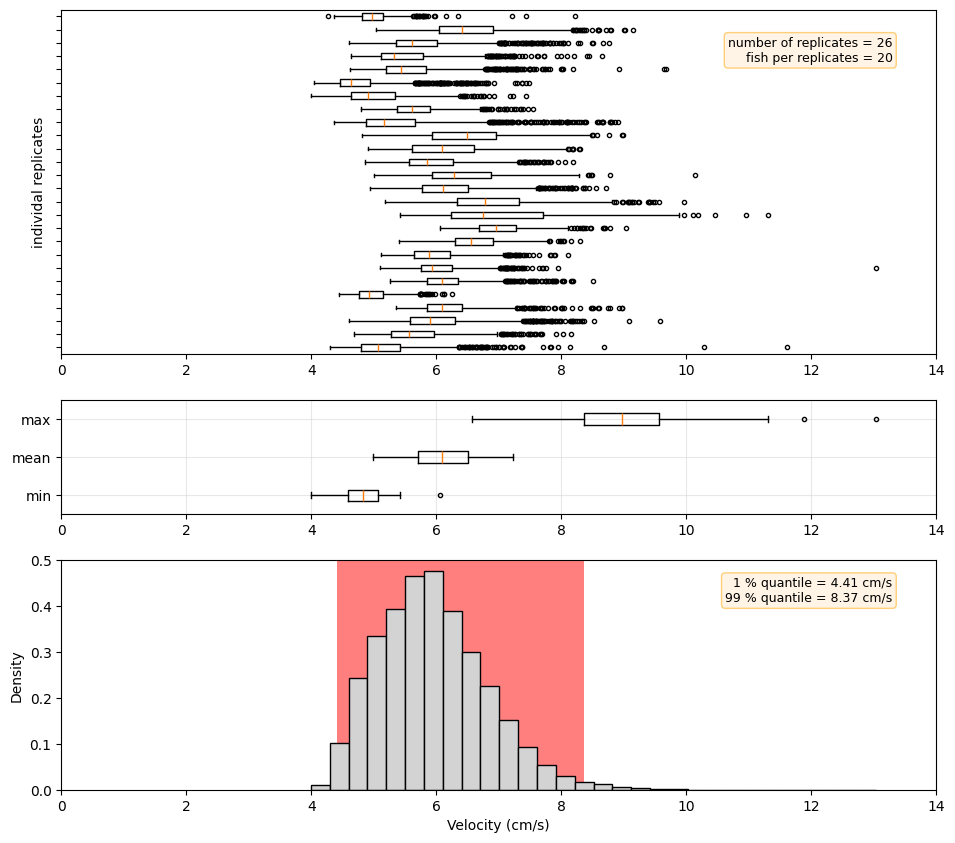

In [116]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10, 12), height_ratios=[3, 1, 2])
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
ax1.boxplot(vel_df_wildtype.dropna(), orientation="horizontal", notch=False, sym='.', whis=1.5)
ax1.set_xlabel("")
ax1.set_yticklabels([])
ax1.set_ylabel("individal replicates")
ax1.set_xlim(0, 14)

# add text box for the statistics
stats = (f'number of replicates = {vel_df_wildtype.shape[1]}\n'
         f'fish per replicates = 20'
         )
         #f'$\\sigma$ = {np.std(y):.2f}\n'
         #f'$r$ = {np.corrcoef(x, y)[0][1]:.2f}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax1.text(0.95, 0.85, stats, fontsize=9, bbox=bbox,
        transform=ax1.transAxes, horizontalalignment='right')

bp = ax2.boxplot(stats_df[["min", "mean", "max"]], orientation="horizontal", notch=False, sym='.',whis=1.5)

ax2.set_yticklabels(["min", "mean", "max"])
ax2.set_xlabel("")

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax2.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
ax2.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax2.set_xlim(0, 14)


merged = pd.Series(vel_df_wildtype.dropna().values.ravel())
s = pl.Series("values", merged)
lower = s.quantile(0.01, interpolation="linear")
upper = s.quantile(0.99, interpolation="linear")
plt.axvspan(lower, upper, color='r', alpha=0.5, lw=0)
ax3.hist(merged, bins=30, density=True, color='lightgrey', edgecolor='black')
ax3.set_xlim(0, 14)
ax3.set_xlabel("Velocity (cm/s)")
ax3.set_ylabel("Density")

# add text box for the statistics
stats = (f'1 % quantile = {lower:.2f} cm/s\n'
         f'99 % quantile = {upper:.2f} cm/s'
         )
         #f'$\\sigma$ = {np.std(y):.2f}\n'
         #f'$r$ = {np.corrcoef(x, y)[0][1]:.2f}')
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax3.text(0.95, 0.82, stats, fontsize=9, bbox=bbox,
        transform=ax3.transAxes, horizontalalignment='right')


Text(0.99, 0.1, '52.99 % below 4.41 cm/s\n28.74 % above 8.37 cm/s')

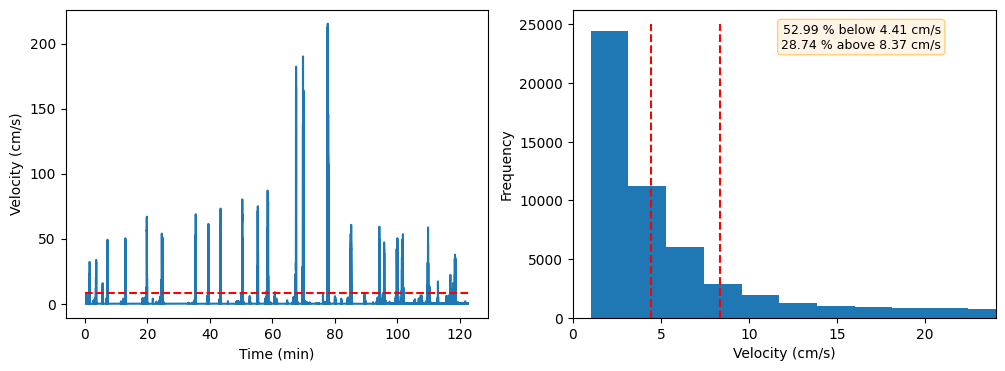

In [205]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(df_VR.select(pl.col("timestamp"))/60, df_VR.select(pl.col("velocity")*100))
ax1.hlines(8.37, 0, 123, colors="red", linestyles="dashed")
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Velocity (cm/s)")

ax2.hist(df_VR.filter(pl.col("velocity")*100 > 1 ).select(pl.col("velocity")*100), bins=100)
ax2.vlines((4.41, 8.37), 0, 25000, colors="red", linestyles="dashed")
ax2.set_xlim(0, 24)
ax2.set_xlabel("Velocity (cm/s)")
ax2.set_ylabel("Frequency")

# add text box for the statistics
percentage_below = len(df_VR.filter(
    (pl.col("velocity")*100 > 1) & 
    (pl.col("velocity")*100 <= 4.41)
)) / len(df_VR.filter(
    (pl.col("velocity")*100 > 1))) * 100 

percentage_above = len(df_VR.filter(
    (pl.col("velocity")*100 > 8.37) 
)) / len(df_VR.filter(
    (pl.col("velocity")*100 > 1))) * 100 

stats = (f'{percentage_below:.2f} % below {lower:.2f} cm/s\n'
         f'{percentage_above:.2f} % above {upper:.2f} cm/s'
         )

bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
ax2.text(0.99, 0.1, stats, fontsize=9, bbox=bbox,
        transform=ax3.transAxes, horizontalalignment='right')